In [1]:
# general imports 
import allensdk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

In [2]:
# set data path
import sys
import platform
from os.path import join as pjoin

platstring = platform.platform()
system = platform.system()
if system == "Darwin":
    # macOS                         
    data_dir = "/Volumes/Brain2025/"
elif system == "Windows":
    # Windows (replace with the drive letter of USB drive)
    data_dir = "E:/"
elif "amzn" in platstring:
    # then on CodeOcean
    data_dir = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_dir = "/media/$USERNAME/Brain2025/"
    
print('data directory set to', data_dir)

data directory set to /Volumes/Brain2025/


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Load the Project Cache</h2> 
    
The code below shows how to use the VisualBehaviorNeuropixelsProjectCache class to load metadata tables and explore the features of the dataset. 

In [3]:
# import behavior project cache class to load the data
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorNeuropixelsProjectCache

cache_dir = r'/Users/marinag/Documents/Data/visual_behavior_neuropixels_cache_dir'

ecephys_cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(cache_dir=cache_dir)


/Users/marinag/anaconda3/envs/allensdk_bou/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# What attributes and methods are available as part of the cache? 
dir(ecephys_cache)[-30:] # Ignore the beginning attributes, they arent needed

['__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cache_not_implemented',
 'cache',
 'cloud_api_class',
 'compare_manifests',
 'construct_local_manifest',
 'current_manifest',
 'fetch_api',
 'fetch_tries',
 'from_lims',
 'from_local_cache',
 'from_s3_cache',
 'get_behavior_session',
 'get_behavior_session_table',
 'get_channel_table',
 'get_ecephys_session',
 'get_ecephys_session_table',
 'get_probe_table',
 'get_unit_table',
 'latest_downloaded_manifest_file',
 'latest_manifest_file',
 'list_all_downloaded_manifests',
 'list_manifest_file_names',
 'load_latest_manifest',
 'load_manifest',
 'logger',
 'manifest']

In [5]:
# The unit table has all the QC metrics
all_units_table = ecephys_cache.get_unit_table()
print(len(all_units_table), 'total units')
all_units_table.head()

319013 total units


,ecephys_channel_id,ecephys_probe_id,ecephys_session_id,amplitude_cutoff,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,cumulative_drift,d_prime,structure_acronym,...,valid_data,amplitude,waveform_duration,waveform_halfwidth,PT_ratio,recovery_slope,repolarization_slope,spread,velocity_above,velocity_below
unit_id,,,,,,,,,,,,,,,,,,,,,
1157005856,1157001834,1046469925,1046166369,0.500000,8453.0,3353.0,6719.0,140.32,6.088133,MB,...,True,143.066332,0.151089,0.096147,0.310791,-0.113863,0.480656,20.0,-0.457845,NaN
1157005853,1157001834,1046469925,1046166369,0.323927,8453.0,3353.0,6719.0,239.76,4.635583,MB,...,True,90.709418,0.357119,0.192295,0.531490,-0.075261,0.366371,30.0,2.060302,-2.060302
1157005720,1157001786,1046469925,1046166369,0.044133,8575.0,3842.0,6590.0,263.32,5.691955,MRN,...,True,90.433103,0.521943,0.178559,0.612217,-0.012119,0.269843,80.0,0.000000,0.863364
1157006074,1157001929,1046469925,1046166369,0.000583,8212.0,2477.0,6992.0,154.64,6.049284,NOT,...,True,287.492107,0.343384,0.192295,0.470194,-0.178335,1.129324,40.0,1.373534,0.000000
1157006072,1157001929,1046469925,1046166369,0.500000,8212.0,2477.0,6992.0,242.58,4.745499,NOT,...,True,157.897057,0.329648,0.164824,0.488276,-0.105005,0.660135,70.0,0.412060,0.343384


In [6]:
# Apply QC criteria
good_units = all_units_table[
    (all_units_table.isi_violations<.5) &
    (all_units_table.amplitude_cutoff<.1) &
    (all_units_table.presence_ratio>.95)
    ]
print(len(good_units), 'units passing QC criteria')

114061 units passing QC criteria


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Load the ecephys session table</h2>

The AllenSDK has specific accessor methods to load the CSVs and return a pandas DataFrame with a row for each item and column for each metadata metric. 
    
Let's load the ecephys_session_table.csv using the `get_ecephys_session_table` method of the cache object.  


In [7]:
ecephys_session_table = ecephys_cache.get_ecephys_session_table() 
ecephys_session_table.head()

,behavior_session_id,date_of_acquisition,equipment_name,session_type,mouse_id,genotype,sex,project_code,age_in_days,unit_count,...,channel_count,structure_acronyms,image_set,prior_exposures_to_image_set,session_number,experience_level,prior_exposures_to_omissions,file_id,abnormal_histology,abnormal_activity
ecephys_session_id,,,,,,,,,,,,,,,,,,,,,
1044385384,1044408432,2020-08-19 14:47:08.574000+00:00,NP.1,EPHYS_1_images_G_5uL_reward,524761,wt/wt,F,NeuropixelVisualBehavior,151,2179,...,1920,"['CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg', 'LGv...",G,30,1,Familiar,0,870,NaN,NaN
1044594870,1044624428,2020-08-20 15:03:56.422000+00:00,NP.1,EPHYS_1_images_H_5uL_reward,524761,wt/wt,F,NeuropixelVisualBehavior,152,2103,...,1920,"['CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg', 'HPF...",H,0,2,Novel,1,872,NaN,NaN
1047969464,1048005547,2020-09-02 14:53:14.347000+00:00,NP.1,EPHYS_1_images_G_3uL_reward,509808,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,263,2438,...,2304,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",G,62,1,Familiar,0,877,NaN,NaN
1047977240,1048009327,2020-09-02 15:15:03.733000+00:00,NP.0,EPHYS_1_images_G_3uL_reward,524925,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,F,NeuropixelVisualBehavior,165,1856,...,2304,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",G,51,1,Familiar,0,878,NaN,NaN
1048189115,1048221709,2020-09-03 14:16:57.913000+00:00,NP.1,EPHYS_1_images_H_3uL_reward,509808,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,264,1925,...,2304,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0,2,Novel,1,879,NaN,NaN


In [8]:
ecephys_session_table.session_type.unique()

array(['EPHYS_1_images_G_5uL_reward', 'EPHYS_1_images_H_5uL_reward',
       'EPHYS_1_images_G_3uL_reward', 'EPHYS_1_images_H_3uL_reward'],
      dtype=object)

In [9]:
# Let's get a novel session
novel_sessions = ecephys_session_table[(ecephys_session_table.prior_exposures_to_image_set==0)]

print('Number of sessions that have novel images: {}'.format(len(novel_sessions.index.unique())))
novel_sessions.head()

Number of sessions that have novel images: 52


,behavior_session_id,date_of_acquisition,equipment_name,session_type,mouse_id,genotype,sex,project_code,age_in_days,unit_count,...,channel_count,structure_acronyms,image_set,prior_exposures_to_image_set,session_number,experience_level,prior_exposures_to_omissions,file_id,abnormal_histology,abnormal_activity
ecephys_session_id,,,,,,,,,,,,,,,,,,,,,
1044594870,1044624428,2020-08-20 15:03:56.422000+00:00,NP.1,EPHYS_1_images_H_5uL_reward,524761,wt/wt,F,NeuropixelVisualBehavior,152,2103,...,1920,"['CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg', 'HPF...",H,0,2,Novel,1,872,NaN,NaN
1048189115,1048221709,2020-09-03 14:16:57.913000+00:00,NP.1,EPHYS_1_images_H_3uL_reward,509808,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,264,1925,...,2304,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0,2,Novel,1,879,NaN,NaN
1048196054,1048222325,2020-09-03 14:25:07.290000+00:00,NP.0,EPHYS_1_images_H_3uL_reward,524925,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,F,NeuropixelVisualBehavior,166,2288,...,2304,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0,2,Novel,1,880,NaN,NaN
1049514117,1049542142,2020-09-10 15:11:15.371000+00:00,NP.0,EPHYS_1_images_H_3uL_reward,521466,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,F,NeuropixelVisualBehavior,194,1925,...,2304,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0,2,Novel,1,882,NaN,NaN
1051155866,1052162536,2020-09-17 15:05:39.665000+00:00,NP.1,EPHYS_1_images_H_3uL_reward,524760,wt/wt,F,NeuropixelVisualBehavior,180,1922,...,2304,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0,2,Novel,1,883,NaN,NaN


In [10]:
# select an experiment id from the table 
ecephys_session_id = novel_sessions.index.values[0]

# load the data for this ophys experiment from the cache
ecephys_session = ecephys_cache.get_ecephys_session(ecephys_session_id)

/Users/marinag/anaconda3/envs/allensdk_bou/lib/python3.9/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h4>Inspect the session object attributes</h4>
    
Using the `list_data_attributes_and_methods()` method will show us all of the attributes of the `ecephys_session` object. 

In [11]:
ecephys_session.list_data_attributes_and_methods()

['behavior_data_class',
 'behavior_session_id',
 'eye_tracking',
 'eye_tracking_rig_geometry',
 'get_channels',
 'get_current_source_density',
 'get_lfp',
 'get_performance_metrics',
 'get_probes_obj',
 'get_reward_rate',
 'get_rolling_performance_df',
 'get_units',
 'licks',
 'mean_waveforms',
 'metadata',
 'optotagging_table',
 'probes',
 'raw_running_speed',
 'rewards',
 'running_speed',
 'spike_amplitudes',
 'spike_times',
 'stimulus_presentations',
 'stimulus_templates',
 'stimulus_timestamps',
 'task_parameters',
 'trials']

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3>Spike times</h3>
    
Neuropixels spike times are provided as a dictionary where each entry in the dictionary is a unit_id and the values are all the spike times for that unit. 

You can identify the spikes for a given window of time (like a stimulus presentation) but filtering the spike times in that window.

In [12]:
# Get dictionary of spike times
spike_times = ecephys_session.spike_times
spike_times

{1053043293: array([4.07073002e+00, 5.12829024e+00, 5.20372311e+00, ...,
        9.71939219e+03, 9.71987549e+03, 9.72006759e+03]),
 1053043288: array([4.64585985e+00, 4.77695905e+00, 8.32750407e+00, ...,
        9.71956099e+03, 9.71958346e+03, 9.71965366e+03]),
 1053043351: array([4.81435882e+00, 4.81592548e+00, 5.20922308e+00, ...,
        9.71844190e+03, 9.71845873e+03, 9.71849750e+03]),
 1053043669: array([5.55982094e+00, 1.68479521e+01, 2.00222994e+01, ...,
        9.71934199e+03, 9.71953669e+03, 9.71955032e+03]),
 1053043496: array([  22.15261977,   28.27831575,   30.18223747, ..., 9719.7620213 ,
        9719.93358692, 9719.96808671]),
 1053043712: array([3149.48581732, 5001.31435901, 7822.57492285, 7823.51381713,
        7824.19787962, 8403.1597827 , 8408.77421513, 8409.52474389,
        8409.54171045, 8488.28813029, 8514.00724013, 8514.46233736,
        8546.28647664, 8547.65220165, 8578.8961778 , 8579.17684276,
        8595.93070727, 8656.32463901, 8656.41180515, 8659.99301664,

In [13]:
# How many units are there?
unit_ids = list(spike_times.keys())
print(len(unit_ids))

2103


#### Unit QC

In [14]:
# Get the units table for this session - this contains the QC metrics
this_session_units = ecephys_session.get_units()
print(len(this_session_units), 'total units in this session')
this_session_units.head()

2103 total units in this session


,PT_ratio,amplitude,amplitude_cutoff,cluster_id,cumulative_drift,d_prime,firing_rate,isi_violations,isolation_distance,l_ratio,...,presence_ratio,quality,recovery_slope,repolarization_slope,silhouette_score,snr,spread,velocity_above,velocity_below,waveform_duration
id,,,,,,,,,,,,,,,,,,,,,
1053043293,0.419873,86.324843,0.500000,74,298.87,2.699632,3.662242,0.149564,42.465758,0.023775,...,0.99,good,-0.039713,0.297167,0.081873,1.895673,70.0,0.274707,-0.892797,0.576884
1053043288,0.527993,117.233415,0.025645,69,134.73,4.261814,12.605778,0.029617,82.292418,0.001381,...,0.99,good,-0.054013,0.330393,0.139204,2.648165,80.0,0.686767,-0.902608,0.631826
1053043351,0.449367,141.748035,0.006296,129,506.12,NaN,1.567180,2.403103,NaN,0.000000,...,0.99,good,-0.137147,0.594239,0.147792,3.451368,100.0,0.686767,0.183138,0.206030
1053043669,0.460699,142.564793,0.042193,447,252.45,5.008010,3.409879,0.218983,66.848280,0.001987,...,0.99,good,-0.073780,0.453585,0.024059,2.524047,80.0,NaN,-0.351559,0.521943
1053043496,0.357444,171.067260,0.126762,277,188.01,5.759882,3.797377,0.264856,60.761267,0.003970,...,0.99,good,-0.081143,0.570094,0.125446,2.961286,80.0,NaN,-0.809404,0.549414


In [15]:
# Apply QC criteria
good_units = this_session_units[
    (this_session_units.isi_violations<.5) &
    (this_session_units.amplitude_cutoff<.1) &
    (this_session_units.presence_ratio>.95)]
print(len(good_units), 'units passing QC criteria')

755 units passing QC criteria


In [16]:
# Only use the good units from now on
# Get a list of the unit IDs from the table
unit_ids = good_units.index.values

Text(0.5, 1.0, 'Spikes for the first minute of session for first 10 cells')

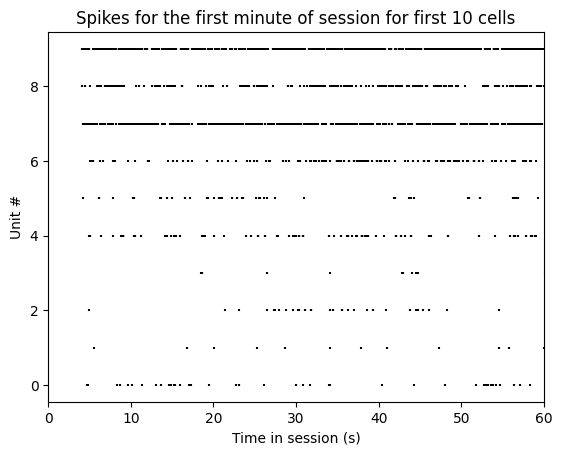

In [17]:
# Get spike times for a few cells and plot it for a short time window
for i, unit_id in enumerate(unit_ids[:10]):
    this_unit_spikes = spike_times[unit_id]
    y_values = np.zeros(len(this_unit_spikes))
    y_values[:] = i
    plt.scatter(this_unit_spikes, y_values, marker='|', color='k', s=2)
    plt.xlim(0, 60)
    plt.ylabel('Unit #')
    plt.xlabel('Time in session (s)')
plt.title('Spikes for the first minute of session for first 10 cells')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3>Stimulus Presentations</h3>
    
The stimulus presentations table contains one entry for each visual stimulus that was presented during the session, along with important metadata about the stimulus. 

In [18]:
stimulus_presentations = ecephys_session.stimulus_presentations
stimulus_presentations.head()

,stimulus_block,image_name,duration,start_time,end_time,start_frame,end_frame,is_change,is_image_novel,omitted,...,active,temporal_frequency,orientation,stimulus_name,position_x,spatial_frequency,stimulus_index,position_y,contrast,rewarded
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,,,
0,0,im104_r,0.250213,26.415843,26.666057,60,75,False,True,False,...,True,NaN,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,NaN,NaN,-99,NaN,NaN,False
1,0,im104_r,0.250213,27.166484,27.416697,105,120,False,True,False,...,True,NaN,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,NaN,NaN,-99,NaN,NaN,False
2,0,im104_r,0.250199,27.917095,28.167294,150,165,False,True,False,...,True,NaN,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,NaN,NaN,-99,NaN,NaN,False
3,0,im104_r,0.250216,28.667709,28.917925,195,210,False,True,False,...,True,NaN,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,NaN,NaN,-99,NaN,NaN,False
4,0,im104_r,0.250199,29.418357,29.668556,240,255,False,True,False,...,True,NaN,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,NaN,NaN,-99,NaN,NaN,False


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3>Behavior measurements</h3>
    
There are 4 behavior modalities collected alongside the 2p images: licks, rewards, running speed, and eye tracking. 
    

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h4>Plot neural activity with stimuli and behavior</h4>
    
Let's plot spike times for one unit along with behavior variables in a second axis, with stimulus presentation times overlaid

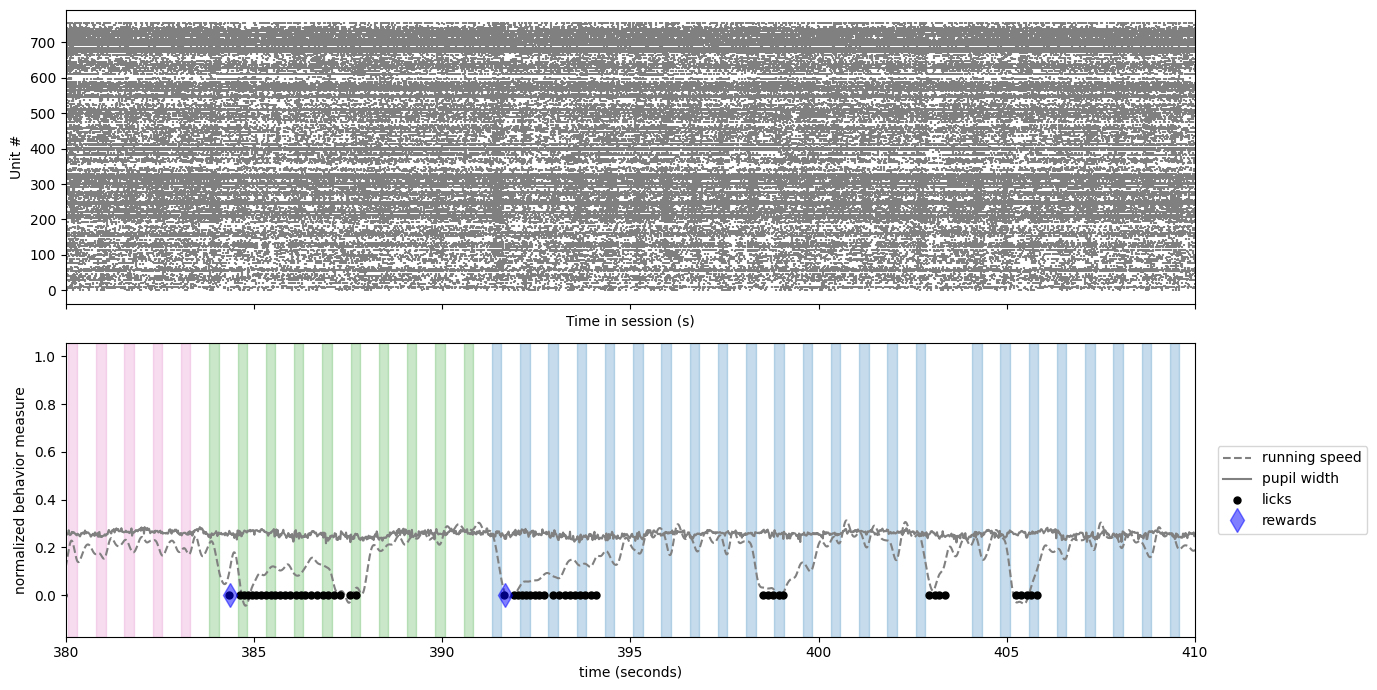

In [19]:
# Set window for plot
initial_time = 380
final_time = 410

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 7), sharex=True)

# Get spike times for all units and plot for the given time window
for i, unit_id in enumerate(unit_ids):
    this_unit_spikes = spike_times[unit_id]
    this_unit_spikes_in_window = this_unit_spikes[(this_unit_spikes>initial_time) & (this_unit_spikes<final_time)]
    y_values = np.zeros(len(this_unit_spikes))
    y_values[:] = i
    ax1.scatter(this_unit_spikes, y_values, marker='|', color='gray', s=1)
    ax1.set_xlim(initial_time, final_time)
    ax1.set_ylabel('Unit #')
    ax1.set_xlabel('Time in session (s)')

# plot running speed - normalized by max 
ax2.plot(
    ecephys_session.running_speed.timestamps,
    ecephys_session.running_speed.speed / ecephys_session.running_speed.speed.max(), 
    '--', color = 'gray', label='running speed'
)

# plot pupil area - normalized by max 
ax2.plot(
    ecephys_session.eye_tracking.timestamps,
    ecephys_session.eye_tracking.pupil_width / ecephys_session.eye_tracking.pupil_width.max(), 
    color = 'gray',label='pupil width'
)
# plot licks
ax2.plot(
    ecephys_session.licks.timestamps,
    np.zeros_like(ecephys_session.licks.timestamps),
    marker='o', color='black', linestyle='none', markersize=5, label='licks'
)

# plot rewards 
ax2.plot(
    ecephys_session.rewards.timestamps,
    np.zeros_like(ecephys_session.rewards.timestamps),
    marker='d', color='blue', linestyle='none', markersize=12, alpha=0.5, label='rewards'
)
ax2.set_xlim([initial_time, final_time])
ax2.set_xlabel('time (seconds)')
ax2.legend(
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    borderaxespad=0
)

# limit stimuli to the relevant time window 
stimuli = stimulus_presentations[(stimulus_presentations.start_time>=initial_time) 
                                 & (stimulus_presentations.end_time<=final_time)]
colors = sns.color_palette()
image_names = stimulus_presentations.image_name.unique()
# plot stimulus presentations on second axis
for idx, stimulus in stimuli.iterrows():
    image_name = stimulus['image_name']
    if image_name !='omitted': # skip plotting for omissions
        color_ind = np.where(image_names==image_name)[0][0]
        ax2.axvspan(stimulus['start_time'], stimulus['end_time'], color=colors[color_ind], alpha=0.25)
ax2.set_ylabel('normalized behavior measure')
ax2.set_xlim([initial_time, final_time])
ax2.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0)


plt.tight_layout()
plt.subplots_adjust(right=0.8)
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Using Brain Observatory Utilities to annotate stimulus presentations and get event aligned traces</h2>

The `brain_observatory_utilities` repository contains tools for manipulating and analyzing Visual Behavior datasets loaded via the AllenSDK, including convenience functions to add useful annotations to the stimulus presentations table, and to extract stimulus or other event aligned traces. The traces that can be used include dF/F, events, spike rates, lick rate, running speed, and pupil diameter. Events that can be used include stimulus start times, rewards, and licks. 
    
You can learn how it works via the tutorial provided in the repo here: https://github.com/AllenInstitute/brain_observatory_utilities/blob/main/example_notebooks/event_triggered_response_example_extended.ipynb
    


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3>Annotate stimulus presentations</h3>

The `get_annotated_stimulus_presentations` function takes in the session or experiment object and adds a bunch of useful columns to the stimulus preentations table. This can be helpful to parse data in different ways and can be linked to the physiology responses for each stimulus to investigate activity under different conditions.  


In [20]:
from brain_observatory_utilities.datasets.behavior import data_formatting as behavior_utils

In [21]:
annotated_stimulus_presentations = behavior_utils.get_annotated_stimulus_presentations(ecephys_session)
annotated_stimulus_presentations.head()

/Users/marinag/Documents/Code/brain_observatory_utilities/brain_observatory_utilities/utilities/general_utilities.py:12: RuntimeWarning: Mean of empty slice.
  return values_this_range.mean()
/Users/marinag/anaconda3/envs/allensdk_bou/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/marinag/Documents/Code/brain_observatory_utilities/brain_observatory_utilities/datasets/behavior/data_formatting.py:528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['change_trials_id'] = trials.index.values


,trials_id,stimulus_block,image_name,duration,start_time,end_time,start_frame,end_frame,is_change,is_image_novel,...,previous_change_on_trial,could_change,pre_change,lick_on_next_flash,pre_omitted,post_omitted,reward_rate,engaged,engagement_state,epoch
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,im104_r,0.250213,26.415843,26.666057,60,75,False,True,...,False,False,False,True,False,<NA>,3.149399,True,engaged,0
1,0,0,im104_r,0.250213,27.166484,27.416697,105,120,False,True,...,False,False,False,True,False,False,3.149399,True,engaged,0
2,0,0,im104_r,0.250199,27.917095,28.167294,150,165,False,True,...,False,False,False,False,False,False,3.149399,True,engaged,0
3,1,0,im104_r,0.250216,28.667709,28.917925,195,210,False,True,...,False,False,False,True,False,False,3.149399,True,engaged,0
4,1,0,im104_r,0.250199,29.418357,29.668556,240,255,False,True,...,False,False,False,False,False,False,3.149399,True,engaged,0


In [22]:
annotated_stimulus_presentations.columns

Index(['trials_id', 'stimulus_block', 'image_name', 'duration', 'start_time',
       'end_time', 'start_frame', 'end_frame', 'is_change', 'is_image_novel',
       'omitted', 'flashes_since_change', 'is_sham_change', 'color', 'active',
       'temporal_frequency', 'orientation', 'stimulus_name', 'position_x',
       'spatial_frequency', 'stimulus_index', 'position_y', 'contrast',
       'rewarded', 'licks', 'first_lick_time', 'lick_latency',
       'mean_running_speed', 'mean_pupil_width', 'change_trials_id',
       'change_time', 'go', 'catch', 'auto_rewarded', 'hit', 'miss',
       'false_alarm', 'correct_reject', 'response_time', 'reward_time',
       'reward_volume', 'time_from_last_change', 'licked',
       'stimulus_count_within_trial', 'previous_image_name',
       'previous_response_on_trial', 'previous_change_on_trial',
       'could_change', 'pre_change', 'lick_on_next_flash', 'pre_omitted',
       'post_omitted', 'reward_rate', 'engaged', 'engagement_state', 'epoch'],
      d

Thats a lot of columns! 

Some useful ones are described below. 

The `flashes_since_change` column tells you how many presentations of the same image have occured since the last image change. 

The `post_omitted` column (a Boolean value) can help you identify the image presentations just after omissions to evaluate whether mice licked following omissions or not. 

The `mean_running_speed` column is the mean running speed in a 500ms window after stimulus onset. 

The `mean_pupil_width` column is the mean running speed in a 500ms window after stimulus onset. 

The `engaged` column tells you whether the mice was in an engaged period (with rolling reward rate >2 rewards / second) for each stimulus presentation. 

There are also many columns related to the task flow and the mouse's performance of the task

In [23]:
# Examine some of the columns related to the task logic
# Talk to Marina if this is confusing (because it is!)
annotated_stimulus_presentations[['image_name',  'trials_id', 'could_change',  'is_change', 'auto_rewarded', 'go', 'catch', 'change_trials_id', 'flashes_since_change', 'licked', 'licks', 'lick_latency', 'reward_time', 'hit', 'miss']][:30]

,image_name,trials_id,could_change,is_change,auto_rewarded,go,catch,change_trials_id,flashes_since_change,licked,licks,lick_latency,reward_time,hit,miss
stimulus_presentations_id,,,,,,,,,,,,,,,
0,im104_r,0,False,False,NaN,NaN,NaN,NaN,0,True,[27.1653],0.749457,NaN,NaN,NaN
1,im104_r,0,False,False,NaN,NaN,NaN,NaN,1,True,"[27.43343, 27.55049, 27.69255]",0.266946,NaN,NaN,NaN
2,im104_r,0,False,False,NaN,NaN,NaN,NaN,2,True,[28.21585],0.298755,NaN,NaN,NaN
3,im104_r,1,False,False,NaN,NaN,NaN,NaN,3,False,[],NaN,NaN,NaN,NaN
4,im104_r,1,False,False,NaN,NaN,NaN,NaN,4,True,[29.75969],0.341333,NaN,NaN,NaN
5,im104_r,2,False,False,NaN,NaN,NaN,NaN,5,False,[],NaN,NaN,NaN,NaN
6,im104_r,2,False,False,NaN,NaN,NaN,NaN,6,True,"[31.33751, 31.51459]",0.417915,NaN,NaN,NaN
7,im104_r,2,False,False,NaN,NaN,NaN,NaN,7,False,[],NaN,NaN,NaN,NaN
8,omitted,3,False,False,NaN,NaN,NaN,NaN,7,False,[],NaN,NaN,NaN,NaN


Description of task logic & performance related columns: 

`trials_id`: the trial number the image presentation belongs to based on the experimenter defined task structure. A trial is composed of many image presentations, starting with a repeated image.
When a trial starts, a change time is drawn from an exponential distribution between 4 and 12 flashes. This means that the image cannot change for at least 4 trials following the trial start. 
If the mouse licks prior to the change time, the trial is aborted and the trial is reset, using the same selected change time for up to 5 trials. 
After the image change occurs, there is a 3 second response window / grace period to allow for reward consumption before the next trial starts. 

`could_change`: indicates whether a stimulus presentation could change based on the task rules. Specifically, whether the image presentation falls in the exponential distribution between 4-12 flashes after trial start. 

`is_change`: whether the stimulus presentation was a change or not

`auto_rewarded`: During the first 3-5 trials of each session, mice are given a free reward at the time of the image change. 
This communicates to the mouse that reward is available and that it is time to do the task.

`go`: whether the image presentation was a change and reward delivery was contingent on the animals licking behavior. 
Go trials can be hits or misses depending on the animal's licking.
Contrast with `auto_rewarded` trials. 

`catch`: whether the image presentation was non-change that conformed to the same statistics as the change time distribution. 
i.e. on each trial, a change time is drawn and the next image identity is randomly selected, and on some trials the same image is selected
this is the maximally conservative definition of a catch trial.
Its important to note that catch trials could also be defined as any non-change image where the stimulus could have changed according to the task rules. 
These non-change image presentations can be identified using the `could_change` column, and can be used to compute false alarm rates with more robustness than the strict definition of catch trials

`change_trials_id`: the trial ID only for stimulus presentations where a change actually occured. 
Will match with `trials_id` but is only listed for stimulus presentations corresponding to image changes. 

`flashes_since_change`: the number of presentations of the same image since the time of the last change_trials_id

`licked`: whether or not the mouse licked during the stimulus presentation window

`licks`: times of all licks during the stimulus presentation window

`lick_latency`: the time of the first lick relative to the stimulus presentation start time

`reward_time`: the time of reward delivery for that stimulus presentation

`hit`: whether the mouse responded correctly on a go trial (licks on auto-rewarded trials are not considered hits)

`miss`: if the mouse did not respond to a change on a go trial


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Stimulus aligned traces</h2>

The `get_stimulus_response_df` function takes in the session or experiment object and pulls out specified timeseries data (indicated by the `data_type`) around the time of stimulus presentations in a window defined by `time_window`. 
    
It will also compute the average of the timeseries in a 500ms window after the stimulus onset (or any duration of window that you set). Setting the `event_type` column to `changes` or `omissions` will return traces aligned to only changes or only omissions, if desired. 

There are different functions for stimulus aligned responses for ophys versus ecephys. 

The `data_type` columm can be `running_speed`, `pupil_width`, or `lick_rate` for either function. 


For neuropixels data, `data_type` can be `spike_rate` and a `spike_rate_bin_size` is provided for binning (default = 10ms). 

For ophys neural data, `data_type` can be `dff`, `events`, or `filtered_events`. 


In [24]:
from brain_observatory_utilities.datasets.stimulus_alignment import data_formatting as alignment_utils

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3>Stimulus running speed</h3>

We can give `data_type` = `running_speed` to get a segment of the running trace around each stimulus presentation using the`get_stimulus_response_df` function. The `time_window` parameter determines how much time around the stimulus presentation is included in the trace segment. 

Then we can merge it with the `annotated_stimulus_presentations` table to get all the stimulus condition information, 
then filter to get change trials for plotting. 


In [25]:
time_window=[-4, 4]
running_stim_df = alignment_utils.get_stimulus_response_df(ecephys_session,
                                    data_type='running_speed',
                                    event_type='all',
                                    time_window=time_window,
                                    response_window_duration=0.5, 
                                    stimulus_block='change_detection_behavior')

100%|██████████| 1/1 [00:00<00:00,  9.57it/s]


In [26]:
# Now we have a dataframe with one row for every stimulus_presentations_id 
# with a segment of the running_speed timeseries in the trace column for each stimulus presentation
running_stim_df.head()

,stimulus_presentations_id,trace_id,trace,trace_timestamps,mean_response,baseline_response,p_value_gray_screen,data_type,event_type,interpolate,output_sampling_rate,response_window_duration,spike_rate_bin_size,stimulus_block
0,0,0,"[-2.246556365851762, -2.132021415703255, -1.91...","[-3.991228957557893, -3.9743883290449906, -3.9...",7.532058,18.022428,0.0,running_speed,all,False,59.380207,0.5,0.01,change_detection_behavior
1,1,0,"[0.7870900939660115, 1.608919673165778, 2.2889...","[-3.991228957557893, -3.9743883290449906, -3.9...",-1.628093,-0.292540,0.0,running_speed,all,False,59.380207,0.5,0.01,change_detection_behavior
2,2,0,"[0.7787274188948823, 0.7260996439886012, 0.629...","[-3.991228957557893, -3.9743883290449906, -3.9...",4.644599,-0.080649,0.0,running_speed,all,False,59.380207,0.5,0.01,change_detection_behavior
3,3,0,"[0.015718842637266636, -0.02666153095509071, -...","[-3.991228957557893, -3.9743883290449906, -3.9...",8.009609,8.786253,0.0,running_speed,all,False,59.380207,0.5,0.01,change_detection_behavior
4,4,0,"[9.18385853456176, 10.118963717069004, 10.7340...","[-3.991228957557893, -3.9743883290449906, -3.9...",3.564759,8.667756,0.0,running_speed,all,False,59.380207,0.5,0.01,change_detection_behavior


In [27]:
# Merge with annotated stimulus presentations so we can subset to specific conditions
# Both tables have the 'stimulus_presentations_id' as a column, and no other unique columns, so we can merge easily
running_stim_df = running_stim_df.merge(annotated_stimulus_presentations, on='stimulus_presentations_id')

In [28]:
# Now we have lots of useful stuff
running_stim_df.columns

Index(['stimulus_presentations_id', 'trace_id', 'trace', 'trace_timestamps',
       'mean_response', 'baseline_response', 'p_value_gray_screen',
       'data_type', 'event_type', 'interpolate', 'output_sampling_rate',
       'response_window_duration', 'spike_rate_bin_size', 'stimulus_block_x',
       'trials_id', 'stimulus_block_y', 'image_name', 'duration', 'start_time',
       'end_time', 'start_frame', 'end_frame', 'is_change', 'is_image_novel',
       'omitted', 'flashes_since_change', 'is_sham_change', 'color', 'active',
       'temporal_frequency', 'orientation', 'stimulus_name', 'position_x',
       'spatial_frequency', 'stimulus_index', 'position_y', 'contrast',
       'rewarded', 'licks', 'first_lick_time', 'lick_latency',
       'mean_running_speed', 'mean_pupil_width', 'change_trials_id',
       'change_time', 'go', 'catch', 'auto_rewarded', 'hit', 'miss',
       'false_alarm', 'correct_reject', 'response_time', 'reward_time',
       'reward_volume', 'time_from_last_change'

Text(0, 0.5, 'Running speed (cm/s)')

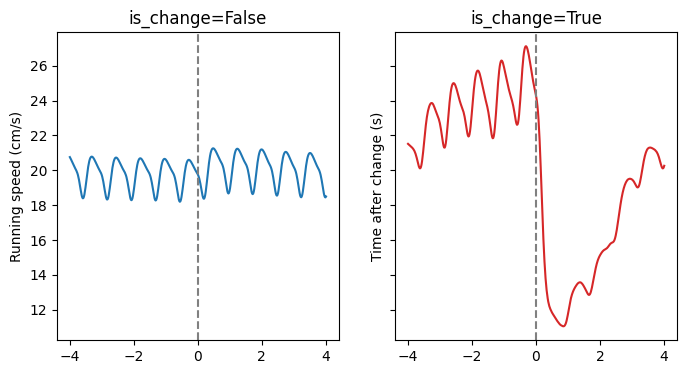

In [29]:
# Let's plot the running for changes and non-changes
fig, ax = plt.subplots(1, 2, figsize=(8,4), sharey=True)

# Get colors for plot (ignoring the second one in seaborn color palette because it is orange and orange is ugly)
colors = sns.color_palette()[0], sns.color_palette()[3]

for i, is_change in enumerate(running_stim_df.is_change.unique()):
    # Get the mean trace across trials for change or no change
    mean_trace = running_stim_df[running_stim_df.is_change==is_change].trace.mean()
    # Get the timestamps from the first row (all rows are the same because we aligned to stim onset)
    timestamps = running_stim_df[running_stim_df.is_change==is_change].trace_timestamps.values[0]
    # Plot it on one axis
    ax[i].plot(timestamps, mean_trace, label=is_change, color=colors[i])
    ax[i].set_title('is_change='+str(is_change))
    ax[i].set_ylabel('Time after change (s)')
    ax[i].axvline(x=0, ymin=0, ymax=1, linestyle='--', color='gray')
    
ax[0].set_ylabel('Running speed (cm/s)')

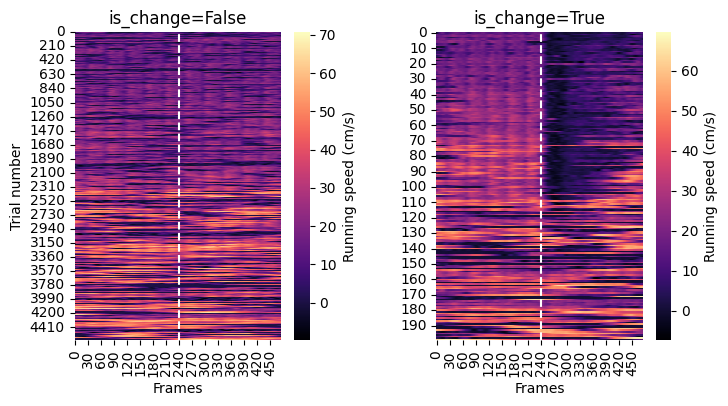

In [30]:
# Let's plot the running for changes and non-changes
fig, ax = plt.subplots(1, 2, figsize=(8,4), sharey=False)

# Get colors for plot (ignoring the second one in seaborn color palette because it is orange and orange is ugly)
colors = sns.color_palette()[0], sns.color_palette()[3]

for i, is_change in enumerate(running_stim_df.is_change.unique()):
    # Turn traces into a matrix for heatmap plotting
    traces = np.vstack(running_stim_df[running_stim_df.is_change==is_change].trace.values)
    # Get the timestamps from the first row (all rows are the same because we aligned to stim onset)
    timestamps = running_stim_df[running_stim_df.is_change==is_change].trace_timestamps.values[0]
    # Plot it on one axis
    ax[i] = sns.heatmap(traces, cmap='magma', cbar_kws={'label':'Running speed (cm/s)'}, ax=ax[i])
    ax[i].set_title('is_change='+str(is_change))
    ax[i].set_xlabel('Frames')
    change_frame = np.abs(time_window[0])*60 # time of change is defined by the time window selected for trace extraction
    # we need to multiple by the stimulus frame rate, which is 60 Hz
    ax[i].axvline(x=change_frame, ymin=0, ymax=1, linestyle='--', color='white')
    
ax[0].set_ylabel('Trial number')
plt.subplots_adjust(wspace=0.4)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3>Stimulus aligned spike rates</h3>

We can give `data_type` = `spike_rate` to get the PSTH for each unit for each stimulus presentation using the`get_stimulus_response_df` function. The `time_window` parameter determines how much time around the stimulus presentation is included in the PSTH. The `spike_rate_bin_size` determines the binning for computing the PSTH.  

The `event_type` parameter can be set to `all` to get the spike rate for all stimulus presentations, or it can be set to `changes` to limit the table to just changes or to `omissions` to limit just to omissions. Since the spike time data is very dense and memory intensive, it can be helpful to limit to changes or omissions. 

Then we can merge it with the `annotated_stimulus_presentations` table to get all the stimulus condition information, 
then filter to get hit trials (or any other condition) for plotting. 


In [31]:
time_window=[-2, 3]
ephys_response_df = alignment_utils.get_stimulus_response_df(ecephys_session,
                                    data_type='spike_rate',
                                    event_type='changes',
                                    time_window=time_window,
                                    response_window_duration=0.5, 
                                    spike_rate_bin_size=0.1,
                                    stimulus_block='change_detection_behavior')

755 units passing QC criteria
spike rate df computed
tidy cell df computed


100%|██████████| 755/755 [00:06<00:00, 125.38it/s]


In [32]:
ephys_response_df.head()

,stimulus_presentations_id,unit_id,trace,trace_timestamps,mean_response,baseline_response,p_value_gray_screen,data_type,event_type,interpolate,output_sampling_rate,response_window_duration,spike_rate_bin_size,stimulus_block
0,34,1053043226,"[0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 0.0, ...","[-2.0, -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1....",0.500000,0.000000,0.0,spike_rate,changes,False,10.0,0.5,0.1,change_detection_behavior
1,34,1053043232,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-2.0, -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1....",0.000000,0.000000,0.0,spike_rate,changes,False,10.0,0.5,0.1,change_detection_behavior
2,34,1053043233,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, ...","[-2.0, -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1....",0.166667,0.333333,0.0,spike_rate,changes,False,10.0,0.5,0.1,change_detection_behavior
3,34,1053043241,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-2.0, -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1....",0.166667,0.000000,0.0,spike_rate,changes,False,10.0,0.5,0.1,change_detection_behavior
4,34,1053043258,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-2.0, -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1....",0.000000,0.000000,0.0,spike_rate,changes,False,10.0,0.5,0.1,change_detection_behavior


The stimulus aligned trace dataframe contains the `trace` for each neuron for each stimulus presentation, in the time window provided to the function. In this case the trace is the spike rate, or PSTH, computed with a specified bin size. 

The `trace_timestamps` column provides the timestamps relative to the stimulus onset for each stimulus presentation, which should be the same for all neurons, since the traces were extracted using the same time window relative to stimulus onset. 

There are also columns with the average response in a 500ms window after stimulus onset (the `mean_response` column) and a 500ms window prior to stimulus onset (the `basline_response` column),
 along with a measure of significance of the response, computed as the p-value comparing the `mean_response` for that stimulus presentation to a shuffled distribution of activity from the same cell during the spontaneous activity period prior to the behavior task. 

The remaining columns provide information about how the stim aligned responses were computed, such as which data type was used, the response window duration for computing mean and baseline responses, etc. 


In [33]:
# Get cell responses for one stimulus presentation
# Lets pick an omission trial
stimulus_presentations_id = stimulus_presentations[stimulus_presentations.is_change==True].index.values[10]
# Sub-select the response dataframe for this stimulus presentation ID
change_responses = ephys_response_df[ephys_response_df.stimulus_presentations_id==stimulus_presentations_id]
change_responses.head()


,stimulus_presentations_id,unit_id,trace,trace_timestamps,mean_response,baseline_response,p_value_gray_screen,data_type,event_type,interpolate,output_sampling_rate,response_window_duration,spike_rate_bin_size,stimulus_block
7550,326,1053043226,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[-2.0, -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1....",0.333333,0.5,0.0,spike_rate,changes,False,10.0,0.5,0.1,change_detection_behavior
7551,326,1053043232,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-2.0, -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1....",0.000000,0.0,0.0,spike_rate,changes,False,10.0,0.5,0.1,change_detection_behavior
7552,326,1053043233,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-2.0, -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1....",0.000000,0.0,0.0,spike_rate,changes,False,10.0,0.5,0.1,change_detection_behavior
7553,326,1053043241,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-2.0, -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1....",0.500000,0.0,0.0,spike_rate,changes,False,10.0,0.5,0.1,change_detection_behavior
7554,326,1053043258,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-2.0, -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1....",0.000000,0.0,0.0,spike_rate,changes,False,10.0,0.5,0.1,change_detection_behavior


Text(0.5, 1.0, 'Unit responses for one trial')

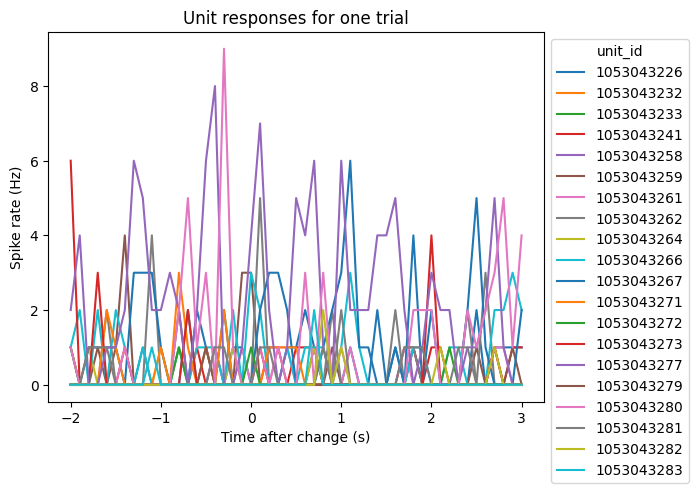

In [34]:

# Lets plot the spike rate for the first 20 neurons for one change trial
fig, ax = plt.subplots()
for i, unit_id in enumerate(change_responses.unit_id.unique()[:20]): 
    trace = change_responses[change_responses.unit_id==unit_id].trace.values[0]
    timestamps = change_responses[change_responses.unit_id==unit_id].trace_timestamps.values[0]
    ax.plot(timestamps, trace, label=unit_id)
# Put the legend with cell IDs outside the plot
ax.legend(bbox_to_anchor=(1,1), title='unit_id')
ax.set_ylabel('Spike rate (Hz)')
ax.set_xlabel('Time after change (s)')
ax.set_title('Unit responses for one trial')

The `traces` in the table are provided as a list of values. To get the traces for a single neuron or single trial as an array, we can use np.vstack. 

In [35]:
# Getting the values of traces for some subset of the dataframe gives an array of arrays
# Let's get the image presentations where there was a hit and pick the 10th one in the list
stimulus_presentations_id = annotated_stimulus_presentations[annotated_stimulus_presentations.hit==True].index.values[10]
# Now filter the responses dataframe to get that image presentation - this gives all cell responses for this trial
hit_trial_activity = ephys_response_df[ephys_response_df.stimulus_presentations_id==stimulus_presentations_id].trace.values
# We selected all cell responses for one trial, so the shape of the result is the number of neurons 
print(hit_trial_activity.shape) 

(755,)


In [36]:
# Using vstack can turn the data into a matrix of neurons by timepoints
trial_activity_matrix = np.vstack(hit_trial_activity)
print(trial_activity_matrix.shape)

(755, 51)


Text(0.5, 1.0, 'Activity of all units for stim #476')

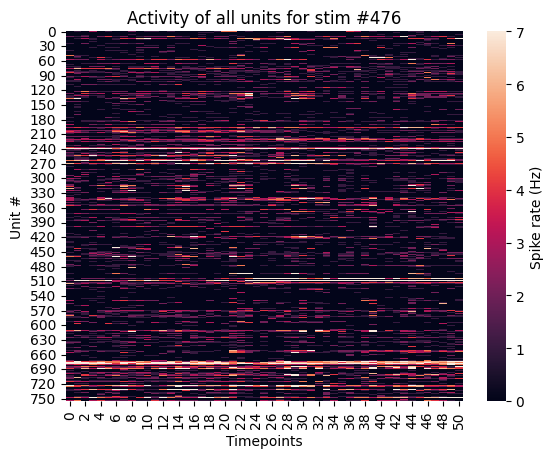

In [37]:
# Now we can plot it as a heatmap
fig, ax = plt.subplots()
ax = sns.heatmap(trial_activity_matrix, vmax=7, cbar_kws={'label':'Spike rate (Hz)'})
ax.set_ylabel('Unit #')
ax.set_xlabel('Timepoints')
ax.set_title('Activity of all units for stim #'+str(stimulus_presentations_id))

#### Plot a heatmap of cell activity traces averaged across hit trials

In [38]:
# Merge with annotated stimulus presentations so we can subset to specific conditions
# Both tables have the 'stimulus_presentations_id' as a column, and no other unique columns, so we can merge easily
ephys_response_df = ephys_response_df.merge(annotated_stimulus_presentations, on='stimulus_presentations_id')

In [39]:
VISp_units = all_units_table.loc[good_units.index.values][(all_units_table['structure_acronym'].str.contains('VISp'))].index.values

/var/folders/bp/23y492js7lz2gvjzgsw6cg_m0000gp/T/ipykernel_48059/3342041623.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  VISp_units = all_units_table.loc[good_units.index.values][(all_units_table['structure_acronym'].str.contains('VISp'))].index.values


In [41]:
# Limit response dataframe to changes for VISp
hit_responses = ephys_response_df[(ephys_response_df.hit==True)&(ephys_response_df.unit_id.isin(VISp_units))]
# Loop through each cell and take the average across trials, 
# then add the result to a list (which can be converted to a matrix) for plotting
responses_list = []
for unit_id in hit_responses.unit_id.unique():
    mean_trace = hit_responses[hit_responses.unit_id==unit_id].trace.mean()
    responses_list.append(mean_trace)

hit_response_matrix = np.asarray(responses_list)

Text(0.5, 1.0, 'Average hit response across VISp units')

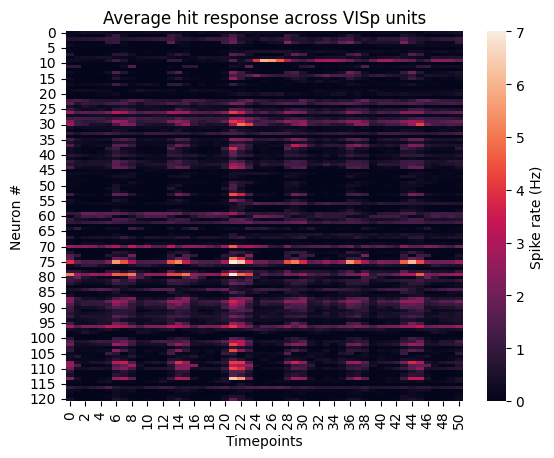

In [42]:
# Now we can plot it as a heatmap
fig, ax = plt.subplots()
ax = sns.heatmap(hit_response_matrix, vmax = 7, cbar_kws={'label':'Spike rate (Hz)'})
ax.set_ylabel('Neuron #')
ax.set_xlabel('Timepoints')
ax.set_title('Average hit response across VISp units')

#### Get a population vector across trials

We can use the `mean_response` column to get a single value for each trial for each cell. 
This is typically called a "population vector" and can be used for a variety of analyses, such as decoding or dimensionality reduction. 

The pandas method `pivot` can be useful to reorganize the data. 

In [43]:
# pivot to get mean change response over trials
population_vector_over_trials = ephys_response_df.pivot(index='unit_id', 
                                                               columns=['stimulus_presentations_id'], 
                                                               values=['mean_response'])
# drop the 'mean_response' label, which isnt needed
population_vector_over_trials.columns = population_vector_over_trials.columns.droplevel(level=0)

population_vector_over_trials.head()

stimulus_presentations_id,34,50,65,75,93,137,171,207,241,254,...,4696,4707,4717,4727,4738,4748,4761,4775,4786,4796
unit_id,,,,,,,,,,,,,,,,,,,,,
1053043226,0.500000,0.500000,0.333333,0.5,0.666667,0.333333,0.166667,0.833333,0.833333,0.500000,...,1.000000,0.500000,1.333333,0.166667,0.833333,0.166667,0.166667,0.5,2.0,0.500000
1053043232,0.000000,0.166667,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,...,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.0,0.0,0.000000
1053043233,0.166667,0.500000,0.000000,0.0,0.666667,0.000000,0.333333,0.000000,0.000000,0.166667,...,0.500000,0.666667,0.333333,0.000000,0.166667,0.000000,1.000000,0.5,0.5,0.333333
1053043241,0.166667,0.000000,0.000000,0.0,0.166667,0.500000,0.166667,0.166667,0.166667,0.000000,...,0.666667,0.833333,1.166667,1.000000,1.000000,1.000000,0.666667,0.5,0.5,1.000000
1053043258,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.333333,0.0,0.0,0.000000


In [44]:
# get just the visual cortex units
visual_units = all_units_table.loc[good_units.index.values][(all_units_table['structure_acronym'].str.contains('VIS'))].index.values

/var/folders/bp/23y492js7lz2gvjzgsw6cg_m0000gp/T/ipykernel_48059/3770773745.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  visual_units = all_units_table.loc[good_units.index.values][(all_units_table['structure_acronym'].str.contains('VIS'))].index.values


[Text(0, 0, '0'), Text(0, 281, '281')]

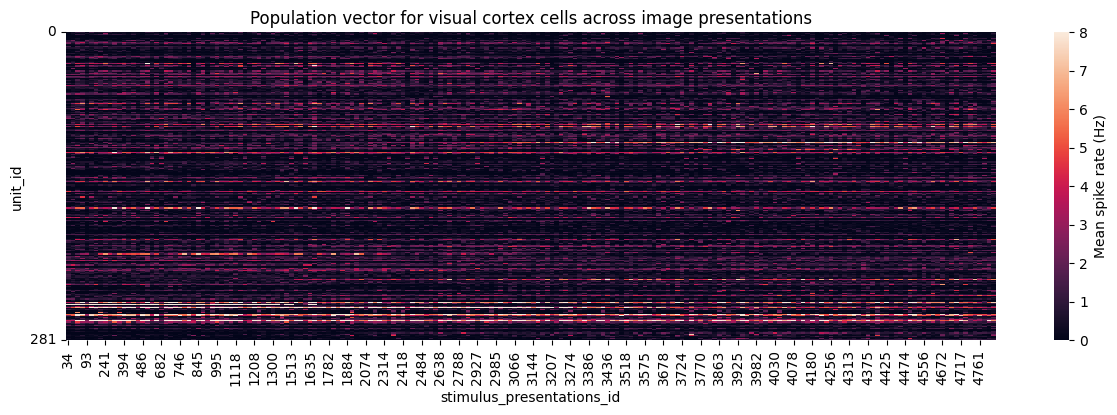

In [45]:
# plot the population vector
fig, ax = plt.subplots(figsize=(15,4))
vis_pop_vector = population_vector_over_trials.loc[visual_units]
ax = sns.heatmap(vis_pop_vector, vmax = 8, cbar_kws={'label':'Mean spike rate (Hz)'}, ax=ax)
ax.set_title('Population vector for visual cortex cells across image presentations')
ax.set_yticks([0, len(vis_pop_vector)])
ax.set_yticklabels([0, len(vis_pop_vector)])

In [46]:
hpc_units = all_units_table.loc[good_units.index.values][all_units_table['structure_acronym'].str.contains('CA')].index.values

/var/folders/bp/23y492js7lz2gvjzgsw6cg_m0000gp/T/ipykernel_48059/1169000679.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  hpc_units = all_units_table.loc[good_units.index.values][all_units_table['structure_acronym'].str.contains('CA')].index.values


[Text(0, 0, '0'), Text(0, 176, '176')]

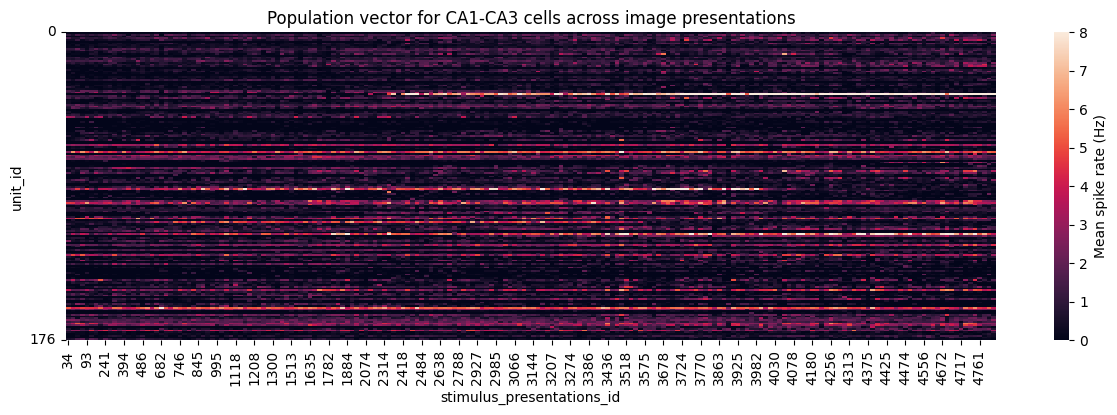

In [47]:
fig, ax = plt.subplots(figsize=(15,4))
hpc_pop_vector = population_vector_over_trials.loc[hpc_units]
ax = sns.heatmap(hpc_pop_vector, vmax = 8, cbar_kws={'label':'Mean spike rate (Hz)'}, ax=ax)
ax.set_title('Population vector for CA1-CA3 cells across image presentations')
ax.set_yticks([0, len(hpc_pop_vector)])
ax.set_yticklabels([0, len(hpc_pop_vector)])

#### Mean population response across familiar and novel image transitions

In [91]:
# Get mean response across the population for each image transition 
mean_image_responses = ephys_response_df.groupby(['image_name', 'previous_image_name']).mean()[['mean_response']]

/var/folders/bp/23y492js7lz2gvjzgsw6cg_m0000gp/T/ipykernel_48059/1658759392.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_image_responses = ephys_response_df.groupby(['image_name', 'previous_image_name']).mean()[['mean_response']]


In [92]:
mean_image_response = mean_image_responses.reset_index()
mean_image_response_matrix = mean_image_response.pivot(index='previous_image_name', columns=['image_name'], values=['mean_response'])
mean_image_response_matrix.columns = mean_image_response_matrix.columns.droplevel(level=0)
mean_image_response_matrix

image_name,im005_r,im024_r,im034_r,im083_r,im087_r,im104_r,im111_r,im114_r
previous_image_name,,,,,,,,
im005_r,NaN,1.004857,0.977999,0.870033,0.953698,0.990453,0.906347,1.008664
im024_r,0.915820,NaN,0.980059,0.933996,0.957689,0.931402,0.867605,1.055188
im034_r,0.945364,0.918690,NaN,0.888687,0.993598,1.018911,0.876674,0.924338
im083_r,0.962141,0.999724,0.971818,NaN,0.954912,1.014790,0.913907,1.032965
im087_r,0.938705,0.971799,0.975331,0.814496,NaN,0.941556,0.879194,1.005464
im104_r,1.020971,1.024172,1.043819,0.892715,0.898400,NaN,0.936424,0.976968
im111_r,0.991998,1.011626,0.991832,0.884161,0.989238,1.062914,NaN,0.980905
im114_r,0.955408,1.008057,0.993488,0.890508,0.935762,0.898308,0.896137,NaN


In [93]:
# get image names sorted by novelty (first two will be shared images)
sorted_image_names = annotated_stimulus_presentations.groupby(['image_name', 'is_image_novel']).count().reset_index()[['image_name', 'is_image_novel']].sort_values(by=['is_image_novel']).image_name.values
sorted_image_names

array(['im083_r', 'im111_r', 'im005_r', 'im024_r', 'im034_r', 'im087_r',
       'im104_r', 'im114_r'], dtype=object)

In [94]:
# sort response matrix by image familiarity 
mean_image_response_matrix = mean_image_response_matrix.loc[sorted_image_names][sorted_image_names]

<Axes: xlabel='image_name', ylabel='previous_image_name'>

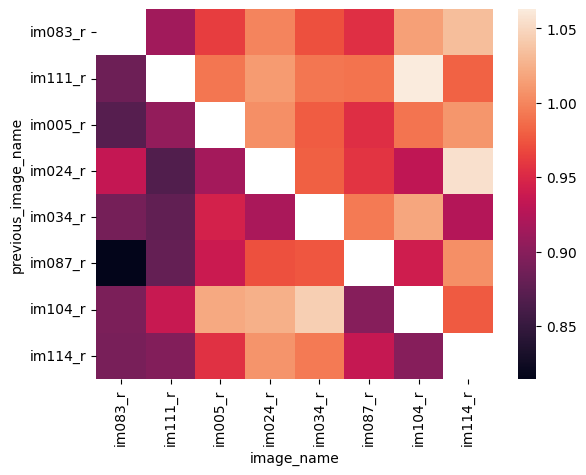

In [95]:
sns.heatmap(mean_image_response_matrix)

#### Compare visual cortex and hippocampus

In [96]:
# get VIS and HPC units
# Get mean response across the population for each image transition for VISp
mean_image_response_VISp = ephys_response_df[ephys_response_df.unit_id.isin(visual_units)].groupby(['image_name', 'previous_image_name']).mean()[['mean_response']]

# Get mean response across the population for each image transition for CA1-CA3
mean_image_response_HPC = ephys_response_df[ephys_response_df.unit_id.isin(hpc_units)].groupby(['image_name', 'previous_image_name']).mean()[['mean_response']]

/var/folders/bp/23y492js7lz2gvjzgsw6cg_m0000gp/T/ipykernel_48059/4140290591.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_image_response_VISp = ephys_response_df[ephys_response_df.unit_id.isin(visual_units)].groupby(['image_name', 'previous_image_name']).mean()[['mean_response']]
/var/folders/bp/23y492js7lz2gvjzgsw6cg_m0000gp/T/ipykernel_48059/4140290591.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_image_response_HPC = ephys_response_df[ephys_response_df.unit_id.isin(hpc_units)].groupby(['image_name', 'previous_image_name']).mean()[['mean_response']]


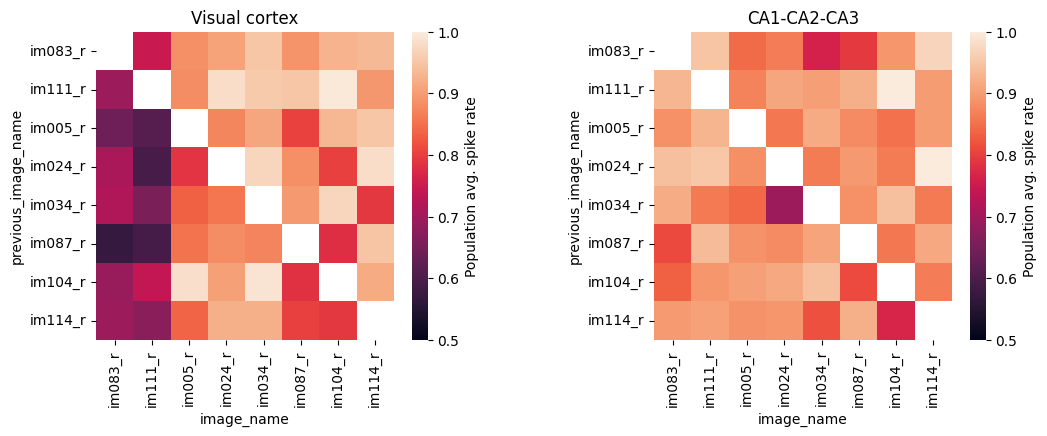

In [97]:
# Now do it all for each VISp and HPC and plot 

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# For VISp
mean_image_response = mean_image_response_VISp.reset_index()
mean_image_response_matrix = mean_image_response.pivot(index='previous_image_name', columns=['image_name'], values=['mean_response'])
mean_image_response_matrix.columns = mean_image_response_matrix.columns.droplevel(level=0)
# get image names sorted by novelty (first two will be shared images)
sorted_image_names = annotated_stimulus_presentations.groupby(['image_name', 'is_image_novel']).count().reset_index()[['image_name', 'is_image_novel']].sort_values(by=['is_image_novel']).image_name.values
# sort response matrix by image familiarity 
mean_image_response_matrix = mean_image_response_matrix.loc[sorted_image_names][sorted_image_names]
# plot 
ax[0] = sns.heatmap(mean_image_response_matrix, vmax=1, vmin=0.5, cbar_kws={'label':'Population avg. spike rate'}, ax=ax[0])
ax[0].set_title('Visual cortex')

# For HPC
mean_image_response = mean_image_response_HPC.reset_index()
mean_image_response_matrix = mean_image_response.pivot(index='previous_image_name', columns=['image_name'], values=['mean_response'])
mean_image_response_matrix.columns = mean_image_response_matrix.columns.droplevel(level=0)
# get image names sorted by novelty (first two will be shared images)
sorted_image_names = annotated_stimulus_presentations.groupby(['image_name', 'is_image_novel']).count().reset_index()[['image_name', 'is_image_novel']].sort_values(by=['is_image_novel']).image_name.values
# sort response matrix by image familiarity 
mean_image_response_matrix = mean_image_response_matrix.loc[sorted_image_names][sorted_image_names]
# plot 
ax[1] = sns.heatmap(mean_image_response_matrix, vmax=1, vmin=0.5, cbar_kws={'label':'Population avg. spike rate'}, ax=ax[1])
ax[1].set_title('CA1-CA2-CA3')

plt.subplots_adjust(wspace=0.5)